<a href="https://colab.research.google.com/github/kentaojapi/dl-style-transfer/blob/master/imageTransferTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# download API key from google drive
## Original: https://colab.research.google.com/drive/1eufc8aNCdjHbrBhuy7M7X6BGyzAyRbrF#scrollTo=y5_288BYp6H1
## When you run for the first time, you will see a link to authenticate.

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

In [0]:
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Add, Activation, Input, Lambda, Conv2DTranspose
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras import backend as K

import math
import glob
import datetime
import pickle
import numpy as np
from matplotlib.pyplot import imshow

In [0]:
def residual_block(input_ts):
  """
  Residual Block
  """
  x = Conv2D(128, (3,3), strides=1, padding='same')(input_ts)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  return Add()([x, input_ts])

In [0]:
def build_encoder_decoder(input_shape=(224, 224, 3)):
  # encoder
  input_ts = Input(shape=input_shape, name='input')

  ## normalize input data
  x = Lambda(lambda a: a/255.)(input_ts)
  
  x = Conv2D(32, (9, 9), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  ## add Residual Block five times
  for _ in range(5):
    x = residual_block(x)
    
  # Decoder
  x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Conv2DTranspose(3, (9, 9), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)

  gen_out = Lambda(lambda a: (a+1)*127.5)(x)
  
  model_gen = Model(
      inputs=[input_ts],
      outputs=[gen_out]
  )
  
  return model_gen

input_shape = (224, 224, 3)

model_gen = build_encoder_decoder(
    input_shape=input_shape
)

In [0]:
# load pretrained vgg16
vgg16 = VGG16()

# layers can't learn anymore
for layer in vgg16.layers:
  layer.trainable = False

In [0]:
# preprocess input data for vgg16
def norm_vgg16(x):
  """
  RBG -> BGR変換ト近似的に中心化を行う関数
  """
  return (x[:, :, :, ::-1] - 120)/255.

In [0]:
# define the names of featuer layers
style_layer_names = {
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
}

contents_layer_names = {'block3_conv3'}

In [0]:
# list to save the output from middle layer 
style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output # 変換NWの出力を損失NWの入力とする

z  = Lambda(norm_vgg16)(input_gen)
for layer in vgg16.layers:
  z = layer(z)
  if layer.name in style_layer_names:
    style_outputs_gen.append(z)
  if layer.name in contents_layer_names:
    contents_outputs_gen.append(z)

In [0]:
model = Model(
    inputs=model_gen.input, 
    outputs=style_outputs_gen + contents_outputs_gen
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


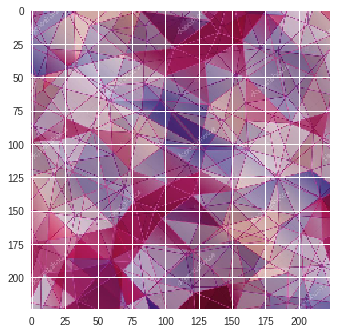

In [37]:
from google.colab import drive
drive.mount('/content/drive')


file_img = "../content/drive/My Drive/machine_learning/ImageTransfer/poligon2.jpg"
input_size = input_shape[:2]

# load the sytle img
img_sty = load_img(
    file_img,
    target_size=input_size
)

imshow(img_sty)

In [0]:
# transfer type of img_sty to np.nadarray
img_arr_sty = np.expand_dims(img_to_array(img_sty), axis=0)

In [0]:
# Model of the Style
## define input layer
input_sty = Input(shape=input_shape, name='input_sty')

## list to save middle layer 
style_outputs = []
x = Lambda(norm_vgg16)(input_sty)

for layer in vgg16.layers:
  x = layer(x)
  if layer.name in style_layer_names:
    style_outputs.append(x)
    
## define the model about style
model_sty = Model(
    inputs=input_sty,
    outputs=style_outputs
)
    
y_true_sty = model_sty.predict(img_arr_sty)

In [0]:
# Model of the Contents
input_con = Input(shape=input_shape, name='input_con')

contents_outputs = []
y = Lambda(norm_vgg16)(input_con)

for layer in vgg16.layers:
  y = layer(y)
  if layer.name in contents_layer_names:
    contents_outputs.append(y)
    
model_con = Model(
    inputs=input_con,
    outputs=contents_outputs
)

In [0]:
# load_img
def load_imgs(img_paths, target_size=(224, 224)):
  _load_img = lambda x: img_to_array(
      load_img(x, target_size=target_size)
  )
  img_list = [
      np.expand_dims(_load_img(img_path), axis=0)
      for img_path in img_paths
  ]
  return np.concatenate(img_list, axis=0)

In [0]:
# 
def train_generator(img_paths, batch_size, model, y_true_sty, shuffle=True, epochs=None):
  n_samples = len(img_paths)
  indices = list(range(n_samples))
  steps_per_epoch = math.ceil(n_samples / batch_size)
  img_paths = np.array(img_paths)
  cnt_epoch = 0
  while True:
      cnt_epoch += 1
      if shuffle:
          np.random.shuffle(indices)
      for i in range(steps_per_epoch):
          start = batch_size * i
          end = batch_size * (i+1)
          X = load_imgs(img_paths[indices[start:end]])
          batch_size_act = X.shape[0]
          y_true_sty_t = [
            np.repeat(feat, batch_size_act, axis=0) for feat in y_true_sty
          ]
          y_true_con = model.predict(X)
          yield (X, y_true_sty_t + [y_true_con])
      if epochs is not None:
          if cnt_epoch >= epochs:
              raise StopIteration

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
!mkdir ../content/img/
!mkdir ../content/img_resized/

In [0]:
# export blob names from GCS
## refer : https://github.com/GoogleCloudPlatform/python-docs-samples/blob/master/storage/cloud-client/snippets.py 
from google.cloud import storage

def list_blobs(bucket_name='imagenet-ojapi'):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client('My First Project')
    bucket = storage_client.get_bucket(bucket_name)

    blobs = bucket.list_blobs()
    imgs_name_list = []
    for blob in blobs:
        imgs_name_list.append(blob.name)
    return imgs_name_list

In [0]:
# download imgs of contents
## refer : https://github.com/GoogleCloudPlatform/python-docs-samples/blob/master/storage/cloud-client/snippets.py
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client('My First Project')
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))


imgs_name_list = list_blobs()
error_counts = 0
for img_name in imgs_name_list:
  download_blob('imagenet-ojapi', '{}'.format(img_name), '../content/img/{}'.format(img_name))
  try:
    img_resized = load_img('../content/img/{}'.format(img_name), target_size=input_size)
    img_resized.save('../content/img_resized/{}'.format(img_name))  
  except OSError:
    error_counts += 1
    print(error_counts)
    pass
  
from IPython.display import clear_output
clear_output()

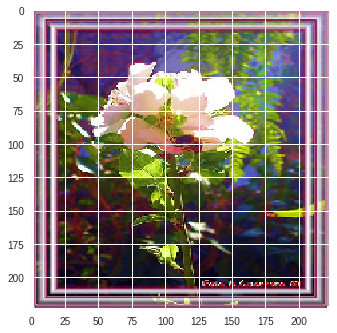

In [34]:
img_resized = load_img('../content/img/n00017222_1009.jpg', target_size=input_size)
imshow(img_resized)

In [0]:
import os

path_glob = "../content/img_resized/*.jpg"
img_paths = glob.glob(path_glob)

batch_size = 2
epochs = 10

gen = train_generator(
    img_paths,
    batch_size,
    model_con,
    y_true_sty,
    epochs=epochs
)

In [0]:
# loss
def feature_loss(y_true, y_pred):
    """
    the loss function for contents
    """
    norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
    return K.sum(
        K.square(y_pred - y_true), axis=(1,2,3)
        )/norm

    
def gram_matrix(X):
    """
    gram matrix
    """
    X_sw = K.permute_dimensions(
        X, (0, 3, 2, 1)
    )
    s = K.shape(X_sw)
    new_shape = (s[0], s[1], s[2]*s[3])
    X_rs = K.reshape(X_sw, new_shape)
    X_rs_t = K.permute_dimensions(
        X_rs, (0, 2, 1)
    )
    dot = K.batch_dot(X_rs, X_rs_t)
    norm = K.prod(K.cast(s[1: ], 'float32'))
    return dot/norm

  
def style_loss(y_true, y_pred):
    """
    the loss function for style.
    """
    return K.sum(
        K.square(
            gram_matrix(y_pred) - gram_matrix(y_true)
        ),
        axis=(1,2)
    )

In [0]:
dt = datetime.datetime.now()
dir_log = "../content/drive/My Drive/machine_learning/model/{:%y%m%d_%H%M%S}".format(dt)
dir_weights = "../content/drive/My Drive/machine_learning/model/{:%y%m%d_%H%M%S}/weights".format(dt)
dir_trans = "../content/drive/My Drive/machine_learning/model/{:%y%m%d_%H%M%S}/img_trans".format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

In [0]:
# compile of model
model.compile(
    optimizer=Adadelta(),
    loss=[
        style_loss,
        style_loss,
        style_loss,
        style_loss,
        feature_loss
    ],
    loss_weights=[1.0, 1.0, 1.0, 1.0, 3.0]
)

In [54]:
# learn 
file_test = '../content/drive/My Drive/machine_learning/ImageTransfer/test/forest.jpg'

img_test = load_img(
    file_test,
    target_size=input_size
)
img_arr_test = img_to_array(img_test)
img_arr_test = np.expand_dims(
    img_to_array(img_test),
    axis=0
)

steps_per_epoch = math.ceil(len(img_paths)/batch_size)

iters_verbose = 1000
iters_save_img = 1000
iters_save_model = steps_per_epoch

now_epoch = 0
losses = []
path_tmp = 'epoch_{}_iters_{}_loss_{:.2f}_{}'
for i, (x_train, y_train) in enumerate(gen):
  
    if i % steps_per_epoch == 0:
        now_epoch += 1

    loss = model.train_on_batch(x_train, y_train)
    losses.append(loss)

    if i % iters_verbose == 0:
        print(
            'epochs:{}, iters:{}, loss:{:.3f}'.format(
                now_epoch, i, loss[0]
            )
        )

    if i % iters_save_img == 0:
        pred = model_gen.predict(img_arr_test)
        img_pred = array_to_img(pred.squeeze())
        path_trs_img = path_tmp.format(
            now_epoch, i, loss[0], '.jpg'
        )
        img_pred.save(
            os.path.join(
                dir_trans,
                path_trs_img
            )
        )
        print('# image saved:{}'.format(path_trs_img))

    if i % iters_save_model == 0:
        model.save(
            os.path.join(
                dir_weights,
                path_tmp.format(
                    now_epoch, i, loss[0], '.h5'
                )
            )
        )
        path_loss = os.path.join(dir_log, 'loss.pkl')
        with open(path_loss, 'wb') as f:
            pickle.dump(losses, f)

epochs:1, iters:0, loss:2504.709
# image saved:epoch_1_iters_0_loss_2504.71_.jpg
epochs:1, iters:1000, loss:176.814
# image saved:epoch_1_iters_1000_loss_176.81_.jpg
epochs:1, iters:2000, loss:122.098
# image saved:epoch_1_iters_2000_loss_122.10_.jpg
epochs:1, iters:3000, loss:125.668
# image saved:epoch_1_iters_3000_loss_125.67_.jpg
epochs:1, iters:4000, loss:161.554
# image saved:epoch_1_iters_4000_loss_161.55_.jpg
epochs:2, iters:5000, loss:112.487
# image saved:epoch_2_iters_5000_loss_112.49_.jpg
epochs:2, iters:6000, loss:97.464
# image saved:epoch_2_iters_6000_loss_97.46_.jpg
epochs:2, iters:7000, loss:122.978
# image saved:epoch_2_iters_7000_loss_122.98_.jpg
epochs:2, iters:8000, loss:102.156
# image saved:epoch_2_iters_8000_loss_102.16_.jpg
epochs:2, iters:9000, loss:99.842
# image saved:epoch_2_iters_9000_loss_99.84_.jpg
epochs:3, iters:10000, loss:96.723
# image saved:epoch_3_iters_10000_loss_96.72_.jpg
epochs:3, iters:11000, loss:144.957
# image saved:epoch_3_iters_11000_los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: generator 'train_generator' raised StopIteration


In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 224, 224, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 224, 224, 32) 7808        lambda_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 224, 224, 32) 128         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation